# **Εργαστήριο**: "Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα"
## **Ασκηση 2: Μη επιβλεπόμενη μάθηση**

## Στοιχεία ομάδας

### **Ομάδα M.Β.11**

- Αλεξόπουλος Άγγελος, el15404
- Γιαννακούλιας Γεώργιος, el15044
- Καλντής Μιχαήλ, el15123

<!-- | Επώνυμο | Όνομα  | ΑΜ |
|-------------------------|:----------:|---------:|
| Αλεξόπουλος   | Άγγελος  | el15404 |
| Γιαννακούλιας | Γεώργιος | el15044 |
| Καλντής        | Μιχαήλ  | el15123 |
|<img width=200/> |<img width=200/> |<img width=200/> | -->


## Εισαγωγή του Dataset

Για αρχή, κάνουμε install κάποια πακέτα που είναι απαραίτητα:

In [104]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

Requirement already up-to-date: pip in /home/mike/jubyter/my_project_env/lib/python3.6/site-packages (20.0.2)
Requirement already up-to-date: numpy in /home/mike/jubyter/my_project_env/lib/python3.6/site-packages (1.18.1)
Requirement already up-to-date: pandas in /home/mike/jubyter/my_project_env/lib/python3.6/site-packages (0.25.3)
Requirement already up-to-date: nltk in /home/mike/jubyter/my_project_env/lib/python3.6/site-packages (3.4.5)
Requirement already up-to-date: scikit-learn in /home/mike/jubyter/my_project_env/lib/python3.6/site-packages (0.22.1)
Requirement already up-to-date: joblib in /home/mike/jubyter/my_project_env/lib/python3.6/site-packages (0.14.1)


Κάνουμε και τα απαραίτητα imports που θα χρειαστούν για τη συνέχεια:

In [105]:
# global imports
import pandas as pd
import numpy as np
import joblib
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('wordnet') # for stemmer/lemmatizer
nltk.download('rslp')
nltk.download('punkt') # for tokenizer
nltk.download('stopwords') # download stopwords file 
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from nltk.tag.stanford import StanfordNERTagger

[nltk_data] Downloading package wordnet to /home/mike/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /home/mike/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /home/mike/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mike/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) (dataset με περίπου 40.000 περιγραφές ταινιών), οπότε το εισάγουμε στο dataframe `df_data_1`.

In [106]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Ωστόσο, θα δουλέψουμε με ένα υποσύνολο 5.000 ταινιών, όπως υπαγορεύει η εκφώνηση. Το seed για την ομάδα μας είναι το 26:

In [107]:
team_seed_number = 26

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1RRoiOjhD0JB3l4oHNFOmPUqZHDphIdwL"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο

## Προεπεξεργασία Δεδομένων

Η προεπεξεργασία των δεδομένων παίζει καταλυτικό ρόλο στη δημιουργία ορθού και γρήγορου συστήματος συστάσεων. Ορίζουμε τη συνάρτηση `tokenize` (η οποία στη συνέχεια θα δοθεί σαν παράμετρος στον `TfidfVectorizer`) και η οποία περιέχει όλα τα βήματα της προεπεξεργασίας:

- *Βήμα 1*: Αρχικά, αφαιρούμε τους χαρακτήρες που δεν ανήκουν στους πρώτους 128 χαρακτήρες σύμφωνα με τον ascii πίνακα (βασικοί χαρακτήρες).
- *Βήμα 2*: Χωρίζουμε το κείμενό μας σε λέξεις (tokens) με τη βοήθεια της `nltk.word_tokenize`
- *Βήμα 3*: Χρησιμοποιούμε τον `StanfordNERTagger` (Named Entity Recognition) για να εξάγουμε ονόματα ανθρώπων και τοποθεσιών, τα οποία μπορεί να αποπροσανατολίσουν το σύστημα σύστασης ταινιών και να θεωρήσει όμοιες ταινίες κάποιες που έχουν ίδια ονόματα στους ηθοποιούς και στις τοποθεσίες, ενώ μπορεί να πρόκειται για τελείως διαφορετικές ταινίες. Αφαιρούμε λοιπόν από το corpus των ταινιών ονόματα ανθρώπων και τοποθεσιών και στη συνέχεια, μετατρέπουμε τα υπόλοιπα tokens σε πεζά (`lower`). Είναι σημαντικό να γίνει η μετατροπή των tokens σε πεζά μετά τη χρήση του NERTagger, αλλιώς δε θα έχει κανένα αποτέλεσμα. 
- *Βήμα 4*: Αφαιρούμε στη συνέχεια όλα τα stopwords και τα punctuations, μιας και δεν παίζουν κανένα ρόλο στο σύστημα συστάσεων.
- *Βήμα 5*: Έπειτα, μέσω της `thorough_filter` ελέγχουμε αν υπάρχουν παραπάνω από ένα σημεία στίξης συνεχόμενα, προκειμένου να τα αφαιρέσουμε επίσης.
- *Βήμα 6*: Τέλος, οι λέξεις που έχουν απομείνει περνάνε μέσω του stemmer, ώστε να αφαιρεθεί η κατάληξή τους και να πετύχουμε καλύτερη ομαδοποίηση των λέξεων.

Θέτουμε αρχικά τις μεταβλητές και τα paths που χρειάζονται για τη χρήση του `StanfordNERTagger`. Η εκτέλεση της εργασίας έγινε στο Jupyter σε υπολογιστή με λειτουργικό Ubuntu 18.04.

In [109]:
JAVA_HOME = '/usr/lib/jvm/java-1.11.0-openjdk-amd64'
# First we set the direct path to the NER Tagger.
_model_filename = '/home/mike/jupyter/my_project_env/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
_path_to_jar = '/home/mike/jupyter/my_project_env/stanford-ner-2018-10-16/stanford-ner.jar'
# Then we initialize the NLTK's Stanford NER Tagger API with the DIRECT PATH to the model and .jar file.
st = StanfordNERTagger(model_filename=_model_filename, path_to_jar=_path_to_jar)

Παρακάτω φαίνεται η συνάρτηση `thorough_filter` η οποία περιγράφηκε προηγουμένως: 

In [110]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

Ακολουθεί η `tokenize` συνάρτηση που περιέχει όλα τα βήματα της προεπεξεργασίας:

In [111]:
def tokenize(text):
    filtered_words_1 = []
    text = ''.join([i if ord(i) < 128 else '' for i in text])
    tokens = [word for word in nltk.word_tokenize(text)]
    tags = st.tag(tokens)
    for tag in tags:
        if tag[1]!='PERSON' and tag[1]!='LOCATION':
            filtered_words_1.append(tag[0].lower())
    filtered_words_2 = [word for word in filtered_words_1 if word not in stopwords.words('english') + list(string.punctuation)]
    filtered_words_3 = thorough_filter(filtered_words_2)
    stems = [PorterStemmer().stem(item) for item in filtered_words_3]
    return stems

## TF-IDF

Το σύστημα συστάσεων που αναπτύσσουμε βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). Μετατρέπουμε το corpus σε αναπαράσταση tf-idf με τη χρήση της `fit_transform` που ανήκει στον `TfidfVectorizer`. 

Οι επιλογές των μεθόδων της TfidfVectorizer και παραμέτρων της μπορεί να έχουν δραματική επίδραση στην ποιότητα των συστάσεων και είναι διαφορετικές για κάθε dataset, ένω ταυτόχρονα έχουν μεγάλη επίδραση και στη διαστατικότητα των δεδομένων.

Οι παράμετροι της `TfidfVectorizer` που θα χρησιμοποιήσουμε στην υλοποίησή μας είναι οι εξής: 

- **max_df = x**: Αγνοεί τους όρους που εμφανίζονται σε ποσοστό x του συνόλου των κειμένων και πάνω (συχνοί όροι).
- **min_df = y**: Αγνοεί τους όρους οι οποίοι εμφανίζονται σε ποσοστό μικρότερο από y του συνόλου των κειμένων (σπάνιοι όροι).
- **lowercase = False**: Η τιμή αυτή θα παραμείνει στο False, ώστε να μη γίνουν όλα τα γράμματα πεζά πρωτού κάνουμε την αφαίρεση των ονομάτων και των τοποθεσιών από τον `StanfordNERTagger` (παίζει ρόλο αν ξεκινάει με κεφαλαίο ή πεζό το πρώτο γράμμα για να αφαιρεθεί μια λέξη από τον NERTagger).
- **tokenizer = tokenizer**: Μέσω της μεταβλητής αυτής ορίζουμε τα βήματα που θέλουμε να κάνει για την προεπεξεργασία των δεδομένων. Του περνάμε τη συνάρτηση `tokenizer` που ορίσαμε παραπάνω. 

Από τις παραπάνω μεταβλητές που χρησιμοποιούμε, οι δύο τελευταίες παραμένουν σταθερές σε όλες τις εκτελέσεις μας. Μεταβάλλουμε τις τιμές των `max_df` και `min_df` προκειμένου να δούμε πόσους όρους θα κρατήσουμε εν τέλει. Δε θέλουμε ούτε να κρατήσουμε πάρα πολλούς όρους, διότι τότε θα καθυστερεί σημαντικά το σύστημα πρότασής μας και μπορεί να θεωρηθούν όμοιες ταινίες κάποιες που σημασιολογικά δεν είναι, αλλά ούτε πολύ λίγους, με αποτέλεσμα να μη βρούμε ταινίες να προτείνουμε. Και τα δύο είναι κακές πρακτικές για ένα σύστημα ταινιών, οπότε πρέπει να κάνουμε δοκιμές για να δούμε τι ταιριάζει στο σύνολο ταινιών που διαθέτουμε.

Θα πειραματιστούμε για τιμές: 
`max_df: 0.5 έως 0.8`και `min_df: 2 έως 5`

In [189]:
vectorizer1 = TfidfVectorizer(tokenizer=tokenize, max_df=0.7, min_df=2, lowercase=False)
corpus_tfidf1 = vectorizer1.fit_transform(corpus)
print(corpus_tfidf1.shape)

(5000, 13648)


In [190]:
vectorizer2 = TfidfVectorizer(tokenizer=tokenize, max_df=0.5, min_df=3, lowercase=False)
corpus_tfidf2 = vectorizer2.fit_transform(corpus)
print(corpus_tfidf2.shape)

(5000, 10626)


In [191]:
vectorizer3 = TfidfVectorizer(tokenizer=tokenize, max_df=0.5, min_df=2, lowercase=False)
corpus_tfidf3 = vectorizer3.fit_transform(corpus)
print(corpus_tfidf3.shape)

(5000, 13647)


In [192]:
vectorizer4 = TfidfVectorizer(tokenizer=tokenize, max_df=0.5, min_df=5, lowercase=False)
corpus_tfidf4 = vectorizer4.fit_transform(corpus)
print(corpus_tfidf4.shape)

(5000, 7950)


In [193]:
vectorizer5 = TfidfVectorizer(tokenizer=tokenize, min_df=3, lowercase=False)
corpus_tfidf5 = vectorizer5.fit_transform(corpus)
print(corpus_tfidf5.shape)

(5000, 10627)


- Από τις παραπάνω εκτελέσεις, παρατηρούμε ότι η αλλαγή του `max_df` από 0.5 σε 0.7 ή ακόμα και η αφαίρεσή του εντελώς δεν μεταβάλλει το μέγεθος του corpus_tfidf. Ωστόσο, θα κρατήσουμε την τιμή `max_df = 0.5`, καθώς είναι η καλύτερη τακτική να αφαιρούνται όροι που εμφανίζονται σε ένα μεγάλο ποσοστό (πάνω από το 50%) των κειμένων, ακόμα και αν στη δικιά μας περίπτωση δεν έπαιξε καταλυτικό ρόλο. 
- Όσον αφορά το `min_df`, παρατηρούμε ότι η αλλαγή του ακόμα και από 2 σε 3 έχει μεγάλη μεταβολή στο μέγεθος του corpus_tfidf (πόσο μάλλον όταν τίθεται 5). Αυτό που μας αφορά όμως δεν είναι απλά να μειωθούν τα χαρακτηριστικά, αλλά να μειωθούν χωρίς να δημιουργείται αντίκτυπο στην ποιότητα των συστάσεων του συστήματός μας. Μετά απο δοκιμές, παρατηρήσαμε ότι το corpus_tfidf4, που έχει min_df=5 και έχει το μικρότερο shape, προτείνει στο χρήστη τις καλύτερες δυνατές ταινίες. Δεν παρουσιάζει φυσικά πολλές διαφορές με τους άλλους vectorizers, αλλά μας δίνει καλύτερες συστάσεις στις περισσότερες περιπτώσεις (ή παρόμοιες), πετυχαίνοντας ταυτόχρονα να εξάγει περισσότερα χαρακτηριστικά (μικρότερο shape). Επομένως, τα χαρακτηριστικά αυτά που εξάγονται επιπλέον από τον vectorizer4 δεν παίζουν ρόλο στην καλύτερη επιλογή μιας ταινίας και θα τον προτιμήσουμε για να κάνει το σύστημά μας πιο εύρωστο. 
- Για όλους τους παραπάνω λόγους, επιλέγουμε να κρατήσουμε τον `vectorizer4` και το αντίστοιχο `corpus_tfidf4`.

In [239]:
corpus_tfidf = corpus_tfidf4

Υλοποιούμε τη συνάρτηση `content_recommender` όπως ζητείται, η οποία δέχεται δύο ορίσματα: `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.

In [112]:
def content_recommender(target_movie, max_recommendations):
  similarities = cosine_similarity(corpus_tfidf[target_movie,:], corpus_tfidf)
  # similarities[0]: get the similarities for our specified movie
  similarities_sorted = np.argsort(similarities[0])[::-1] # argsort returns indices in ascending order in respect to their values
  print('Target movie', '\nID: ', target_movie, '\nTitle: ', ''.join(titles[target_movie]), '\nSummary: ', ''.join(summaries[target_movie]), '\nCategories:', ''.join(categories[target_movie]))
  print('----------------------------------------------------')
  print('----------------------------------------------------')
  for i in range(max_recommendations):
    recommend = similarities_sorted[i+1]
    print('Recommended movie no ', i+1 , '\nID: ', recommend, '\nTitle: ', ''.join(titles[recommend]), '\nSummary: ', ''.join(summaries[recommend]), '\nCategories:', ''.join(categories[recommend]))
    print('----------------------------------------------------')


Οι 10 ταινίες που θα παρουσιάσουμε είναι οι παρακάτω:

In [241]:
search_titles = ["Airport '77", 'Cruel Jaws', 'Treasure Island', 'The Courage of Kavik the Wolf Dog', 'New Mr. Vampire', 'Boogeyman', 'American Shaolin', 'Crazy Over Horses', 'A Night to Remember', 'Little School Mouse']
cnt = 1
for i in range(titles.shape[0]):
  if titles[i] in search_titles:
    print('Movie ', cnt, ':', titles[i], ' has id ', i)
    cnt = cnt+1

Movie  1 : ['Boogeyman']  has id  841
Movie  2 : ['Cruel Jaws']  has id  1037
Movie  3 : ['American Shaolin']  has id  1058
Movie  4 : ['Treasure Island']  has id  1338
Movie  5 : ['New Mr. Vampire']  has id  1610
Movie  6 : ['Little School Mouse']  has id  2387
Movie  7 : ['A Night to Remember']  has id  4004
Movie  8 : ['Crazy Over Horses']  has id  4041
Movie  9 : ['The Courage of Kavik the Wolf Dog']  has id  4098
Movie  10 : ["Airport '77"]  has id  4161


In [242]:
content_recommender(841, 8)

Target movie 
ID:  841 
Title:  Boogeyman 
Summary:  On the surface, Tim Jensen seems to be a normal person, with a steady job and a good relationship with his girlfriend Jessica. However, a terrifying event that he witnessed as a child has left him traumatized, where his father was taken by the Boogeyman, an evil creature which lives in all closets worldwide. Since then, he has taken precautions to ensure that the Boogeyman cannot get to him, such as sleeping on a mattress on the floor, and removing all closets from his home and keeping all his clothes in a dresser drawer. After a Thanksgiving trip with Jessica to her parents' house, Tim has a premonition in which his Mother tells him to return to the family home. Tim awakes and won't relax until he finds out what happened with his mother. When he phones the hospital, he discovers his mother has died. Upon returning to the psychiatric ward where he grew up after his father died, he discovers that one of the patients, a young girl, is 

In [243]:
content_recommender(1037, 8)

Target movie 
ID:  1037 
Title:  Cruel Jaws 
Summary:  The coastal town of Hampton Bay is threatened when a 35-Foot Great White Shark starts chomping up their vacationers. Days before the annual Regatta celebration, the townspeople are faced with financial ruin if something isn't done about their newfound Shark problem. If that wasn't enough, the owners of the local amusement park have been subject to a hostile takeover from a prospective businessman looking to cash in on their prized property. It's up to the Sheriff, the Park's Owner, and a Shark Expert to head out and destroy the Shark before the summer economy is slashed and the park is left for the bulldozer. 
Categories: "Natural horror films",  "Horror"
----------------------------------------------------
----------------------------------------------------
Recommended movie no  1 
ID:  3284 
Title:  12 Days of Terror 
Summary:  Based on true events that occurred 1—12 July 1916 in Central and Southern New Jersey, as recounted in 

In [244]:
content_recommender(1058, 8)

Target movie 
ID:  1058 
Title:  American Shaolin 
Summary:  During a martial arts tournament, the American finalist Drew Carson  is humiliated by his opponent, kickboxer Trevor Gottitall  who pantses him during the match. To add to the insult, Drew's teacher Master Kwan  confesses that he is not—as he had claimed—a Shaolin monk, and therefore he had not passed on the actual knowledge of Shaolin kung fu to Drew. Determined to learn the actual art to prevent another such situation, Drew departs for China and arrives at the Shaolin Temple. At first, the monks do not let him enter, but with the help of a pretty tea shop waitress, Ashena , and an old monk  who gives him a decisive advise, he waits outside of the temple for a week, after which he manages to be admitted. The old monk also turns out to be the abbot of the temple, Master San De, and he and his stern taskmaster train Drew and a number of other young apprentices in the ways of the Shaolin. At first Drew causes much trouble as hi

In [245]:
content_recommender(1338, 8)

Target movie 
ID:  1338 
Title:  Treasure Island 
Summary:  Jim Hawkins  is a young man who works at a pub with his mother . When a drunken old sailor named Billy Bones  comes in for a drink and dies, Jim gets his hands on an old pirate's treasure map. Immediately taking action, he then enlists the help of Squire Trelawney  and Dr. Livesey  to join him as he locates the island on the map. Together, they join a ship lead by Captain Smollett  that will lead them to their destination. When word of the treasure reaches the rest of the ship's crew, the ship's cook, Long John Silver , convinces the rest of the crew to organize a mutiny in order to keep the riches for themselves. 
Categories: "Family Film",  "Adventure"
----------------------------------------------------
----------------------------------------------------
Recommended movie no  1 
ID:  2956 
Title:  Animal Treasure Island 
Summary:  Jim, the young assistant of the keeper of the Admiral Bembo inn, and his mouse friend Gran  a

In [246]:
content_recommender(1610, 8)

Target movie 
ID:  1610 
Title:  New Mr. Vampire 
Summary:  The brother of a local business baron is killed by a vampire and Chin and his disciple set to bury the corpse but their plans are foiled by Wu who allows the corpse to turn into a vampire. Meanwhile, Hsiao in a grave robbery attempt accidentally awakens a female corpse  who eventually turns out to be the Marshal's  wife. During the commotion, Wu steals the vampire and sets it loose but is restrained by Chin who transports and hides the vampire in a hotel run by Wu Ma. The Marshal discovers them and his reanimated wife but the vampire is let loose once more by Wu and they all team up with the Marshal and his army to stop it. 
Categories: "Comedy horror",  "Horror",  "Chinese Movies"
----------------------------------------------------
----------------------------------------------------
Recommended movie no  1 
ID:  4945 
Title:  From Dusk Till Dawn 3: The Hangman's Daughter 
Summary:   The prequel is set in Mexico in the early

In [247]:
content_recommender(2387, 8)

Target movie 
ID:  2387 
Title:  Little School Mouse 
Summary:   The story opens with Jerry's diploma that qualifies Jerry to teach mice how to outwit cats. Tuffy is the only student at Jerry's school. However, Jerry is late. He is startled by the sound of Jerry being chased around the room outside the hole by Tom. Finally, Jerry reaches the hole, slamming the door shut behind him. He heaves a sigh of relief and straightens both his framed diploma on the wall and his necktie. Jerry begins teaching Tuffy the basics of outwitting a cat by way of a couple of cartoon strips on the chalkboard. The first one demonstrates how the cat chases the mouse and, if he catches the mouse, will eat him. Tuffy begins to cry. Jerry directs his attention to the other picture sequence, which shows the mouse reaching his hole and the cat saying "bad words." Tuffy laughs. For the next lesson, Jerry shows Tuffy an imitation cat's paw in front of a mousehole facade. He demonstrates the procedure and Tuffy goes

In [248]:
content_recommender(4004, 8)

Target movie 
ID:  4004 
Title:  A Night to Remember 
Summary:  The Titanic was the largest vessel afloat, and was widely believed to be unsinkable. Her passengers included the cream of American and British society. The story of her sinking is told from the point of view of her passengers and crew, principally Second Officer Charles Lightoller . Once in the open sea on her maiden voyage, the Titanic receives a number of ice warnings from nearby steamers. Captain Edward J. Smith  is unconcerned and the ship continues on at high speed. Late on 14 April 1912, lookout Frederick Fleet ([[Bernard Fox  spots an iceberg directly in front of the ship. The ship turns hard to port, but the Titanic collides with the iceberg on its starboard side, opening the first five compartments to the sea, below the waterline. Thomas Andrews , the ship's builder, inspects the damage and finds that the ship will soon sink, a bad situation made horrific by the fact the ship does not have sufficient lifeboat capa

In [249]:
content_recommender(4041, 8)

Target movie 
ID:  4041 
Title:  Crazy Over Horses 
Summary:  Louie is owed money by a stable-owner and sends Slip and the boys over to collect the debt. They return with a horse, My Girl, as payment. Local gangsters want the horse and switch their horse, Tarzana, for the gang's horse. They boys discover the ruse and the horses are switched several more times. In the end, Sach rides the real My Girl in a horse race, beating Tarzana and the gangsters. 
Categories: "Sports",  "Comedy film",  "Action"
----------------------------------------------------
----------------------------------------------------
Recommended movie no  1 
ID:  1827 
Title:  Escape from the Dark 
Summary:  Set in a mining town in Yorkshire, the film is about a company that plans to use machines instead of horses to get coal. A group of childred intervene to attempt a rescue of the horses when they are to be killed, but after they are caught, the authorities must decide what to do about the horses. 
Categories: "Fam

In [250]:
content_recommender(4098, 8)

Target movie 
ID:  4098 
Title:  The Courage of Kavik the Wolf Dog 
Summary:  Kavik, a champion sled dog, who has just won a race in Alaska, is sold for $4000 to George Hunter, a ruthless businessman from Seattle, who has local business interests. The plane carrying the dog crashes into the snow-covered wilderness; the pilot is killed and the dog is more dead than alive. The crash site is found by Andy Evans, a young boy who lives in the nearby fishing settlement of Copper City. He struggles to get the dog home and begs his parents to let him ask the local doctor to take a look at Kavik. Dr Walker does, initially reluctantly, have a look and does his best to deal with Kavik's multiple injuries. The dog slowly recovers and starts to bond with Andy. But Hunter arrives on a regular trip and claims back the dog, taking him to a kennel in his palatial Seattle home. Hunter's kennel manager, seeing that the dog is unhappy and unlikely to be a champion racer, allows him to escape. Kavik manage

In [251]:
content_recommender(4161, 8)

Target movie 
ID:  4161 
Title:  Airport '77 
Summary:  A privately owned luxury Boeing 747-100, Stevens' Flight 23  complete with piano bar, office, and bedroom, is used to ferry invited guests to an estate owned by wealthy philanthropist Philip Stevens . Valuable artwork from Stevens's private collection is also on board the jetliner, to be eventually displayed in his new museum. Such a collection motivates a group of thieves led by co-pilot Bob Chambers  to hijack the aircraft in the hopes of landing it on an abandoned airfield on St. George Island. Once Captain Don Gallagher  leaves the cockpit and is knocked unconscious, the hijackers' plans go into motion. A sleeping gas is released into the cabin and the passengers lose consciousness. Knocking out the flight engineer, Chambers puts the plan in motion, and Stevens' Flight 23 "disappears" into the Bermuda Triangle. Descending to virtual wave-top altitude, Flight 23 heads into a fog bank, reducing visibility to less than a mile. Mi

Η θεματική που ενώνει τις ταινίες είναι (με τη σειρά που εμφανίζονται παραπάνω):
1. Θρίλερ - Τρόμου
2. Επιθέσεις Καρχαριών
3. Πολεμικές Τέχνες - Κινέζικη 
4. Θησαυροί και Πειρατές
5. Βαμπίρ
6. Παιδικά
7. Ναυάγια - Καράβια
8. Άλογα
9. Σκυλιά
10. Αεροσκάφοι - Πόλεμος

Αποθηκεύουμε τέλος το corpus_tfidf:

In [252]:
joblib.dump(corpus_tfidf, 'corpus_tfidf.pkl')

['corpus_tfidf.pkl']

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://drive.google.com/uc?export=download&id=1R1R7Ds9UEfhjOY_fk_3wcTjsM0rI4WLl" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

Σημειώστε ότι το IBM Watson δείνει "Kernel dead" εάν δεν έχετε βελτιστοποιήσει το tfidf και μικρύνει τις διαστάσεις του dataset (πιθανότατα κάποια υπέρβαση μνήμης).

In [114]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tfidf.toarray()[0:doc_limit,:] # the best corpus_tfidf selected
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [115]:
final_set = build_final_set()

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [116]:
final_set.shape

(5000, 8272)

Με βάση την εμπειρία σας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, υπάρχει κάποιο βήμα προεπεξεργασίας που θα μπορούσε να εφαρμοστεί σε αυτό το dataset; 

**Απάντηση**

Αντί για τυχαία αρχικοποίηση θα μπορούσαμε να χρησιμοποιήσουμε PCA για την αρχικοποίηση των τιμών για τα βάρη των νευρώνων.

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [117]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Requirement already up-to-date: somoclu in /home/mike/jubyter/my_project_env/lib/python3.6/site-packages (1.7.5)


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.

Παραθέτουμε ένα πίνακα με τις διαφορετικές παραμέτρους για κάθε υλοποίηση Somoclu που εκτελέσαμε κατά την διαδικασία επιλογής παραμέτρων:

| Υλοποίηση  | rows | columns | epochs | movies |clusters |
|-----------|------|---------|--------|--------|---------|
| A         | 5    | 5       | 50     | 500    |4        |
| B         | 20   | 20      | 100    | 1000   |10       |
| C         | 25   | 25      | 100    | 5000   |20       |
| D         | 30   | 30      | 100    | 5000   |15       |
| E         | 40   | 40      | 100    | 5000   |20       |
| F         | 32   | 32      | 100    | 5000   |16       |

Καταλήξαμε ότι οι παράμετροι της υλοποίησης F είναι βέλτιστοι παρατηρώντας τα αποτελέσματα που τυπώνουμε στο τελευταίο section.
- Ο αριθμός των 16 cluster είναι ιδανικός, καθώς είναι αρκετά μεγάλος για να καταφέρνει σωστή ομαδοποίηση στις ταινίες και είναι αρκετά μικρός ώστε να είναι διαχειρίσιμος για την σύγκριση αποτελεσμάτων από άνθρωπο (ο μεγάλος αριθμός cluster μπορεί να επιτυχγάνει λίγο καλύτερα αποτελέσματα, αλλά χάνει από άποψη πρακτικής σημασίας).
- Το γινόμενο 32 * 32 = 1024 αποτελεί καλό αριθμό νευρώνων, καθώς αντιστοιχούν κατα μέσο όρο 5 ταινίες σε κάθε νευρώνα. Ένας στόχος της χρήσης της βιβλιοθήκης Somoclu είναι να επιταχύνει χρονικά την ομαδοποίηση των ταινιών σε clusters. Μια υλοποίηση με παραπάνω νευρώνες (πχ 50 * 50 = 2500) θα είχε μεγάλο χρονικό κόστος χωρίς μεγάλη βελτίωση των αποτελεσμάτων.
- Από το uMatrix παρατηρούμε πολλές μικρές περιοχές χρώματος μπλε-πράσινο, που περιβάλλονται από κίτρινες καμπύλες. Επιπλεόν δεν υπάρχουν μεγάλες κόκκινες περιοχές που δηλώνουν μεγάλη απόσταση μεταξύ γειτονικών νευρώνων. Τα χαρακτηριστικά αυτά αποδεικνύουν ότι η επιλογή παραμέτρων του som ήταν καλή. Ο αριθμός των clusters που επιλέγουμε είναι ανάλογος του πλήθους των μπλε-πράσινων περιοχών.



In [118]:
n_rows, n_columns = 28, 28
n_epochs = 100
n_movies = 5000
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som.train(final_set[:n_movies,:], epochs = n_epochs)

CPU times: user 2h 51min 31s, sys: 7.9 s, total: 2h 51min 39s
Wall time: 15min 22s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [119]:
bmus = som.bmus
# bmus = np.flip(bmus, axis=1) # allagi se grammi, stili
# print(bmus[:10][:])
# print(np.flip(bmus, axis=1)[:10][:]) # flip rows

ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
# print(ubmus)
# print(indices)
# len(ubmus)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [120]:
from sklearn.cluster import KMeans

n_clusters = 30
algorithm = KMeans(n_clusters = n_clusters)

In [121]:
som.cluster(algorithm=algorithm)
clusters = som.clusters
# print(clusters)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [122]:
joblib.dump(som, 'som.pkl')

['som.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



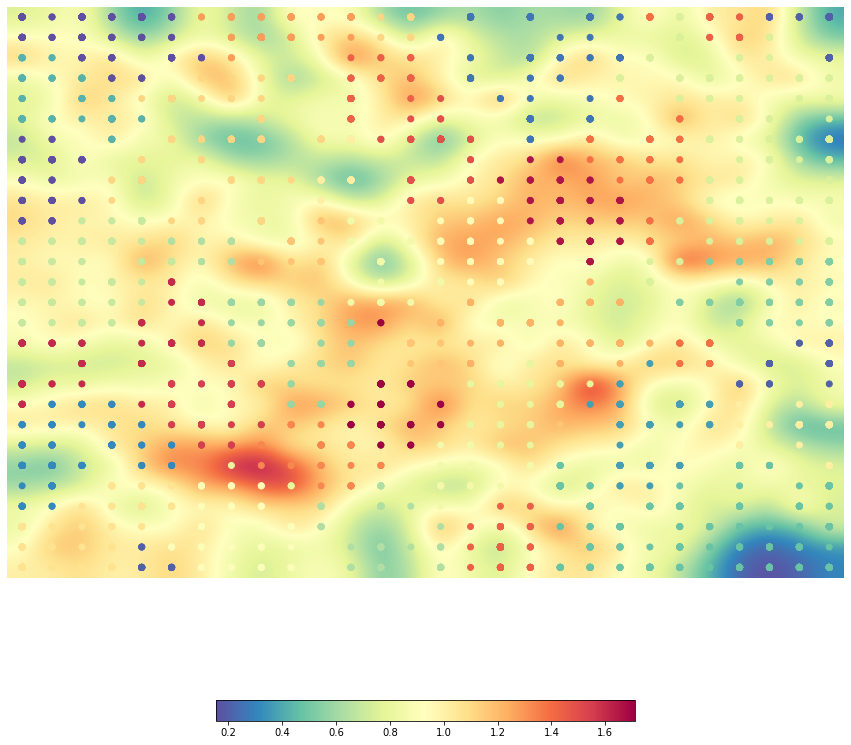

Cluster that each neuron belongs:
 [[ 0  0  0  0  0  0 21 21 21 21 21 21 18 18  2  2  2  2  2  2  2 23 11 24
  24  1  1  1]
 [ 0  0  0  0  0  0 21 21 21 21 21 21 18 18  2  2  2  2  2  2  2 11 11 24
  24 11  1  1]
 [ 5  5  0  0  0  0  0 21 21 18 18 24 24 24  2  2  2  2  2  2  2 11 11 11
  11 11 11  1]
 [ 5  5  5  0  0 18 18 18 18 18 18 24 24 24  2  2  2  2  2  2 11 11 11 11
  11 11 11 11]
 [ 5  5  5  5 18 18 18 18 18 18 24 24 24 24 25  2  2  2  2  2 23 23 11 11
  11 11 11 11]
 [ 5  5  5  5  5 18 18 18 18 18 18 24 18 25 25 25  2  2  2  2 23 23 23 11
  11 11 11 11]
 [ 0  0  0  5 18 18 18 18 18 18 18 16 25 25 25 25 18  2 18 23 23 23 23 11
  11 11 11 11]
 [ 0  0  0  0 18 18 18 18 18 18 18 16 16 25 25 25 25 28 28 23 23 23 23 11
  11 11 11 11]
 [ 0  0  0 18 18 18 18 18 18 18 16 16 16 25 25 25 28 28 28 28 23 23 23 11
  11 11 11 11]
 [ 0  0  0 18 18 18 18 18 18 18 16 16 16 25 25 15 15 28 28 28 28 23 11 11
  11 11 11 11]
 [ 0  0 10 10 10 18 18 18 18 19 19 13 13 13 15 15 15 28 28 28 28 23 11 11
 

In [123]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print('Cluster that each neuron belongs:\n', clusters)

clusters_sorted = np.unique(clusters, return_index = True, return_counts = True)
# print(clusters_sorted)
print('Clusters in increasing order:\n',clusters_sorted[0])
print('Cluster start index:\n',clusters_sorted[1])
print('Neurons per cluster:\n',clusters_sorted[2])



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [124]:
def print_categories_stats(movie_ids):
  n_movies = len(movie_ids)
  all_categories = []
  for movie_id in movie_ids:
    movie_categories = categories[movie_id][0].split(",  ")
    movie_categories = [x.replace('"', '') for x in movie_categories]
    all_categories.extend(movie_categories)
  all_unique_categories, counts_unique_categories = np.unique(all_categories, return_counts = True)
  sorted_indices = reversed(np.argsort(counts_unique_categories))
  print('-'*100)
  print('{:<40} |   {:<30}   |   {:<8}(total: {})'.format('Category', 'Percentage %', 'Counts', n_movies))
  print('-'*100)
  for idx in sorted_indices:
    print('{:<40} |   {:<30}   |   {:<5}'.format( all_unique_categories[idx], counts_unique_categories[idx]/n_movies, counts_unique_categories[idx] ))
  return

# print_categories_stats(list(range(0,500)))

In [125]:
# return movie_ids associated with the specific neuron
def neuron_movies_report(neuron_ids):
  movie_ids = []
  for neuron_id in neuron_ids:
    movies_ids_part = np.where(indices == neuron_id)[0]
    movie_ids.extend(movies_ids_part)
  # print(movie_ids)
  return movie_ids

# neuron_movies_report(print_cluster_neurons_movies_report(3))

In [126]:
def equal_arrays(arA, arB):
  if (len(arA) != len(arB)):
    return False
  for idx in range(0,len(arA)):
    if arA[idx] != arB[idx]:
      return False
  return True

# return neuron_ids associated with the specific cluster
def print_cluster_neurons_movies_report(cluster_id):
  neuron_coords_of_cluster = np.where(clusters == cluster_id) # coords (column-) of neurons of cluster with input id
  neuron_coords_of_cluster = np.column_stack((neuron_coords_of_cluster[0], neuron_coords_of_cluster[1]))
  # print(neuron_coords_of_cluster)
  # print(ubmus)
  neuron_ids_of_cluster = []
  for i in neuron_coords_of_cluster:
    for u_idx in range(0, len(ubmus)):
      if equal_arrays(i, ubmus[u_idx]):
        neuron_ids_of_cluster.append(u_idx)
  neuron_ids_of_cluster = np.array(neuron_ids_of_cluster)
  # print(neuron_ids_of_cluster)
  print('='*100)
  print('\n','Cluster with number', cluster_id, '\n')
  movie_ids = neuron_movies_report(neuron_ids_of_cluster)
  print_categories_stats(movie_ids)
  return neuron_ids_of_cluster

# print(indices)
# print(bmus)
# print(clusters)


In [127]:
for i in range(0, n_clusters):
  print_cluster_neurons_movies_report(i)


 Cluster with number 0 

----------------------------------------------------------------------------------------------------
Category                                 |   Percentage %                     |   Counts  (total: 241)
----------------------------------------------------------------------------------------------------
Horror                                   |   0.6141078838174274               |   148  
Documentary                              |   0.3775933609958506               |   91   
Science Fiction                          |   0.34024896265560167              |   82   
Slasher                                  |   0.21991701244813278              |   53   
Cult                                     |   0.13692946058091288              |   33   
Thriller                                 |   0.12863070539419086              |   31   
Creature Film                            |   0.12448132780082988              |   30   
B-movie                                  |   0.116182

----------------------------------------------------------------------------------------------------
Category                                 |   Percentage %                     |   Counts  (total: 143)
----------------------------------------------------------------------------------------------------
Comedy                                   |   0.8601398601398601               |   123  
Drama                                    |   0.6363636363636364               |   91   
World cinema                             |   0.4405594405594406               |   63   
Comedy-drama                             |   0.3006993006993007               |   43   
Satire                                   |   0.24475524475524477              |   35   
Black comedy                             |   0.22377622377622378              |   32   
Indie                                    |   0.21678321678321677              |   31   
Musical                                  |   0.16783216783216784              |


 Cluster with number 11 

----------------------------------------------------------------------------------------------------
Category                                 |   Percentage %                     |   Counts  (total: 377)
----------------------------------------------------------------------------------------------------
Drama                                    |   0.9734748010610079               |   367  
Romance Film                             |   0.636604774535809                |   240  
Romantic drama                           |   0.5888594164456233               |   222  
World cinema                             |   0.5039787798408488               |   190  
Comedy                                   |   0.16976127320954906              |   64   
Crime Fiction                            |   0.16710875331564987              |   63   
Romantic comedy                          |   0.1246684350132626               |   47   
Indie                                    |   0.11671


 Cluster with number 20 

----------------------------------------------------------------------------------------------------
Category                                 |   Percentage %                     |   Counts  (total: 118)
----------------------------------------------------------------------------------------------------
Action                                   |   0.9661016949152542               |   114  
Adventure                                |   0.635593220338983                |   75   
Action/Adventure                         |   0.6016949152542372               |   71   
Drama                                    |   0.4491525423728814               |   53   
War film                                 |   0.288135593220339                |   34   
Black-and-white                          |   0.211864406779661                |   25   
Comedy                                   |   0.1440677966101695               |   17   
World cinema                             |   0.11864

Supernatural                             |   0.0125                           |   1    
Television movie                         |   0.0125                           |   1    
Coming of age                            |   0.0125                           |   1    
Ensemble Film                            |   0.0125                           |   1    

 Cluster with number 24 

----------------------------------------------------------------------------------------------------
Category                                 |   Percentage %                     |   Counts  (total: 145)
----------------------------------------------------------------------------------------------------
Drama                                    |   0.5655172413793104               |   82   
Comedy                                   |   0.496551724137931                |   72   
Romance Film                             |   0.3931034482758621               |   57   
Thriller                                 |   0.37241


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering έχουμε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής μας. Για ευκολία ξανατυπώνουμε το uMatrix καθώς και τον πίνακα των clusters:

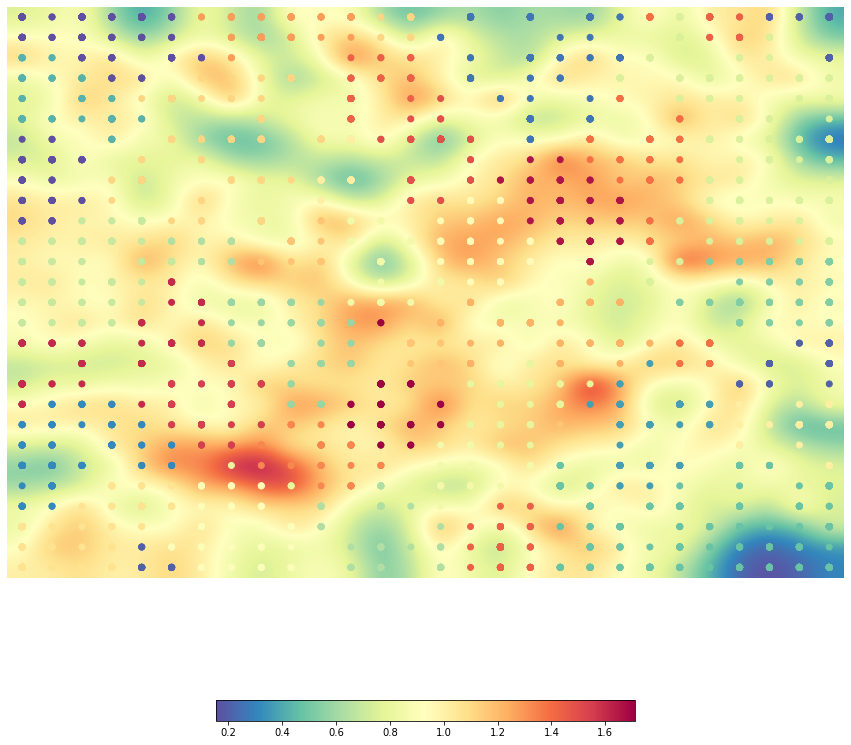

<module 'matplotlib.pyplot' from '/home/mike/jubyter/my_project_env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [128]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))


In [129]:
# force to print whole array
np.set_printoptions(threshold=np.inf)

# print cluster per neuron in array style
print('Cluster that each neuron belongs:\n', clusters)

# print amount of neurons per cluster
print('Amount of neurons per cluster:\n',clusters_sorted[2])


Cluster that each neuron belongs:
 [[ 0  0  0  0  0  0 21 21 21 21 21 21 18 18  2  2  2  2  2  2  2 23 11 24
  24  1  1  1]
 [ 0  0  0  0  0  0 21 21 21 21 21 21 18 18  2  2  2  2  2  2  2 11 11 24
  24 11  1  1]
 [ 5  5  0  0  0  0  0 21 21 18 18 24 24 24  2  2  2  2  2  2  2 11 11 11
  11 11 11  1]
 [ 5  5  5  0  0 18 18 18 18 18 18 24 24 24  2  2  2  2  2  2 11 11 11 11
  11 11 11 11]
 [ 5  5  5  5 18 18 18 18 18 18 24 24 24 24 25  2  2  2  2  2 23 23 11 11
  11 11 11 11]
 [ 5  5  5  5  5 18 18 18 18 18 18 24 18 25 25 25  2  2  2  2 23 23 23 11
  11 11 11 11]
 [ 0  0  0  5 18 18 18 18 18 18 18 16 25 25 25 25 18  2 18 23 23 23 23 11
  11 11 11 11]
 [ 0  0  0  0 18 18 18 18 18 18 18 16 16 25 25 25 25 28 28 23 23 23 23 11
  11 11 11 11]
 [ 0  0  0 18 18 18 18 18 18 18 16 16 16 25 25 25 28 28 28 28 23 23 23 11
  11 11 11 11]
 [ 0  0  0 18 18 18 18 18 18 18 16 16 16 25 25 15 15 28 28 28 28 23 11 11
  11 11 11 11]
 [ 0  0 10 10 10 18 18 18 18 19 19 13 13 13 15 15 15 28 28 28 28 23 11 11
 

#### Στον παρακάτω πίνακα φαίνονται τα cluster που ανήκει κάθε νευρώνας:
```
[ 0  0  0  0  0  0 21 21 21 21 21 21 18 18  2  2  2  2  2  2  2 23 11 24 24  1  1  1]
[ 0  0  0  0  0  0 21 21 21 21 21 21 18 18  2  2  2  2  2  2  2 11 11 24 24 11  1  1]
[ 5  5  0  0  0  0  0 21 21 18 18 24 24 24  2  2  2  2  2  2  2 11 11 11 11 11 11  1]
[ 5  5  5  0  0 18 18 18 18 18 18 24 24 24  2  2  2  2  2  2 11 11 11 11 11 11 11 11]
[ 5  5  5  5 18 18 18 18 18 18 24 24 24 24 25  2  2  2  2  2 23 23 11 11 11 11 11 11]
[ 5  5  5  5  5 18 18 18 18 18 18 24 18 25 25 25  2  2  2  2 23 23 23 11 11 11 11 11]
[ 0  0  0  5 18 18 18 18 18 18 18 16 25 25 25 25 18  2 18 23 23 23 23 11 11 11 11 11]
[ 0  0  0  0 18 18 18 18 18 18 18 16 16 25 25 25 25 28 28 23 23 23 23 11 11 11 11 11]
[ 0  0  0 18 18 18 18 18 18 18 16 16 16 25 25 25 28 28 28 28 23 23 23 11 11 11 11 11]
[ 0  0  0 18 18 18 18 18 18 18 16 16 16 25 25 15 15 28 28 28 28 23 11 11 11 11 11 11]
[ 0  0 10 10 10 18 18 18 18 19 19 13 13 13 15 15 15 28 28 28 28 23 11 11 11 11 11 11]
[10 10 10 10 10  9  9  9 19 19 19 13 13 13 15 15 15 15 28 28 28 23 23 11 11 11 11 11]
[10 10 10 10 10 10  9  9 19 19 19 13 13 13 15 15 15 15 28 28 28 11 11  7  7  7  7  7]
[10 10 10 10 10 27 27  8  8  8 19 13 13 13 13 15 15 15 20 20 20 11 11  7  7  7  7  7]
[10 10 10 10 10 27 27  8  8  8  8 13 13 13 20 20 20 20 20 20 20 20  7  7  7  7  7  7]
[10 10 10 10 27 27 27  8  8  8  8  8 29 19 20 20 20 20 20 20 20 20  7  7  7  7  7  7]
[27 27 27 27 27 27 27  8  8  8  8  8 19 19 19 20 20 20 20 20 20 20 23 23  7  1  1  1]
[27 27 27 27 27 27 26 26  8  8  8  8 29 19 19 20 12 12 20 20 20  4 23 23  1  1  1  1]
[27 27 27 27 27 26 26 26 26  8  8 29 29 29 29 12 12 12 12 12  4  4  4  4  1  1  1  1]
[27  3  3  3 27 26 26 26 26  8  8 29 29 29 29 12 12 12 12  4  4  4  4  4 16 16 16 16]
[ 3  3  3  3  3 26 26 26 26 22 22 29 29 29 29 12 12 12 19  4  4  4  4  4 16 16 16 16]
[ 3  3  3  3  3  3 26 26 22 22 22 22 29 29 13 13 12 12  6  4  4  4  4 16 16 16 16 16]
[ 3  3  3  3  3  3  3 12 22 22 22 22 22 13 13 13 13 13  6  6  4  4  4  6  6  6 16 16]
[ 3  3  3 17 17 17 14 14 14 12 22 22  9 13 13 13 13  6  6  6  4  4  6  6  6  6  6  6]
[ 3  3 17 17 17 17 14 14 14 14  9  9  9  9 13 13 24 24  6  6  6  6  6  6  6  6  6  6]
[17 17 17 17 17 14 14 14 14 14  9  9  9  9  9 24 24 24  6  6  6  6  6  6  6  6  6  6]
[17 17 17 17  1 14 14 14 14 14  9  9  9  9  9 24 24 24  6  6  6  6  6  6  6  6  6  6]
[17 17 17 17  1  1 14 14 14 14  6  9  9  9  9 24 24 24  6  6  6  6  6  6  6  6  6  6]
```

#### Παρακάτω φαίνεται κάθε cluster με τις δύο πιο κοινές κατηγορίες:

cluster  | first  category| percentage | count | second category | percentage | count
---|----|----|---|----|---|---
0| Horror|   0.61|   148 | Documentary|   0.38|   91
1| Drama|   0.81|   156 | Musical|   0.53|   103
2| Drama|   1.0|   205|Thriller|   0.98|   200
3| Comedy|   0.99|   136 | Short Film|   0.74|   102
4| Drama|   1.0|   98|Family Drama|   0.54|   53
5| Horror|   0.81|   151| Japanese Movies|   0.22|   40
6| Drama|   1.0|   712 | Romance Film|   0.19|   134
7| Drama|   0.92|   125 | Crime Fiction|   0.72|   98
8| Fantasy|   0.77|   71| Animation|   0.48|   44
9| Comedy|   0.86|   123|Drama|   0.64|   91
10| Short Film|   0.85|   168|Animation|   0.27|   54
11| Drama|   0.97|   367|Romance Film|   0.64|   240
12| Adventure|   0.91|   53|Drama|   0.90|   52
13| Drama|   0.51|   78 | Comedy|   0.51|   77
14| Comedy|   1.0|   247| Parody|   0.14|   35
15| Action|   1.0|   57| Action/Adventure|   0.842|   48
16| Drama|   0.65|   112|Period piece|   0.27|   46
17| Comedy|   0.99|   194|Romance Film|   0.72|   140
18| Thriller|   0.25|   82| Silent film|   0.14|   47
19| Romance Film|   0.83|   63| Action|   0.32|   24
20| Action|   0.97|   114| Adventure|   0.64|   75
21| Thriller|   1.0|   107| Horror|   0.87|   93
22| Comedy|   0.85|   45| Family Film|   0.72|   38
23| Action|   0.825|   66 | Action/Adventure|   0.8|64
24| Drama|   0.57|   82|Comedy|   0.50|   72
25| Thriller|   0.95|   53| Action|   0.80|   45
26| Family Film|   0.89|   50 |Comedy|   0.46|   26
27| Animation|   0.66|   128| Comedy film|   0.54|   105
28| Action/Adventure|   0.99|   104| Action|0.95|100
29| Adventure|   0.98|   82 | Family Film |   0.30|   25

#### Γενικά

Από το umatrix παρατηρούμε μεγάλες περιοχές μπλε-πράσιονου χρώματος, που περιβάλλονται από κιτνρινό-κόκκινες καμπύλες. Αυτό εκφράζει κοντινούς ομαδοποιημένους γείτονες που έχουν ξεκάθαρα σύνορα με τις υπόλοιοπες ομάδες. Επίσης υπάρχουν ελάχιστες περιοχές με έντονο κόκινο χρώμα, που υποδεικνύουν απομακρυσμένους γείτονες. Συνεπώς ο διαχωρισμός μας σε clusters είναι πολύ καλός.

**Η ομοιότητα των ταινιών ανά cluster αγγίζει κυρίως ποσοστά 90%-100%** (στην κυριότερη κατηγορία), πράγμα που μας δείχνει ότι η ομαδοποίηση μας είναι σωστή. Υπάρχει **μόνο 1 cluster με ποσοστό μικρότερο του 50%** (το cluster 18 που θα αναφερθούμε στην συνέχεια). Ακόμη παρατηρούμε πως τα μεγέθη των ομάδων είναι αρκετά μεγάλα, δηλαδή δεν υπάρχουν ομάδες με τετριμμένα μικρό μέγεθος (πχ 20-30 ταινίες). Αυτό είναι πολύ σημαντικό για να θεωρούμε την ομαδοποίηση μας ουσιώδη.

Τα παραπάνω επιτεύχθηκαν με σωστή επιλογή παραμέτρων τόσο για το μέγεθος του SOM όσο και για τον αριθμό των clusters (που προσσεγιαστικά επιλέξαμε παρατηρώντας το umatrix).

Αξίζει να σημειωθεί πως τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας. Συνεπώς δεν γίνεται όλα τα ποσοστά να είναι στο 100%.

#### Διαδικασία Βελτιστοποίησης

Αρχικά, ακολουθήσαμε μια διαδικασία για να βελτιώσουμε το αριθμό νευρώνων του χάρτη Som ανά γραμμή και ανά στήλη. Για να συγκρίνουμε τα αποτελέσματα των διαφορετικών παραμέτρων ελέγχαμε κατά πόσο η μορφή του uMatrix ήταν αρκετά επιθυμητή (πολλές μπλε-πράσινες περιοχές, λίγες κιτρινο-κόκκινες). 
Για τις παραμέτρους n_rows, n_columns δοκιμάσαμε (20,20), (23,23), (25,25), (28,28), (30,30), (35,35). Τα αποτελέσματα ήταν βέλτιστα στην περιπτώση των ζευγών (28,28) και παραπάνω. Κρατήσαμε τους λιγότερους νευρώνες για να επιταχύνουμε τον υπολογισμό του som και να μειώσουμε το μέγεθος της μνήμης που καταλαμβάνει.

Ένα ενδεικτικό καλής ομαδοποίησης που παρατηρούμε είναι ότι οι δύο κατηγορίες με την μεγαλύτερη συχνότητα για κάθε cluster έχουν μεγάλη συνάφεια. Για παράδειγμα: 
- το cluster 2 έχει κύριες κατηγορίες Drama και Thriller	
- το cluster 15 έχει κύριες κατηγορίες Action και Action/Adventure	
- το cluster 22 έχει κύριες κατηγορίες Comedy και Family Film	

Ταυτόχρονα όμως, το ζευγάρι των συχνότερων κατηγοριών δεν είναι πάντα το ίδιο. Για παράδειγμα:
- το cluster 3 έχει κύριες κατηγορίες Comedy, Short Film
- ενώ το cluster 14 έχει κύριες κατηγορίες Comedy, Parody
- το cluster 19 έχει κύριες κατηγορίες Romance Film, Action
- ενώ το cluster 11 έχει κύριες κατηγορίες Drama, Romance Film		


#### Η πυκνότητα πιθανότητας στο χώρο εισόδου επηρεάζει το πλήθος των κόμβων

Αρχικά παρατηρούμε ότι οι ταινίες που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Για παράδειγμα:
- οι περισσότερες ταινίες ανήκουν στην κατηγορία Drama. Συνεπώς υπάρχουν πολλά clusters από νευρώνες που έχουν το Drama ως κυρίαρχη κατηγορία. Αυτό οδηγεί στο να συγκεντώνονται ομάδες με κατηγορία Drama σε διάφορες περιοχές του χάρτη. Συγκεκριμένα, τα clusters 2, 11  βρίσκονται στο πάνω μέρος του χάρτη. Το cluster 1 στο κάτω μέρος του χάρτη. Τα clusters 4, 6, 16 στο κάτω δεξιά μέρος. 
- αντίθετα, λιγότερες ταινίες ανήκουν στην κατηγορία Short Film και Animation. Παρατηρούμε ότι μόνο τα cluster 10, 27 έχουν αυτές ως κύριες κατηγορίες και είναι τοποθετημένα στο αριστερά μέρος του χάρτη.

#### Μακρινά πρότυπα εισόδου εμφανίζονται απομακρυσμένα και στον χάρτη του SOM

Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη. Για παράδειγμα:

- οι ταινίες comedy, family film, animation είναι τοποθετημένες στο αριστερά μέρος του χάρτη (clusters 10, 14, 17, 3, 27) ενώ αντίθετα
- οι ταινίες drama, thriller είναι τοποθετημένες στο πάνω και πάνω δεξιά μέρος του χάρτη (clusters 11, 2) ενώ οι drama, comedy, romance film (οι λίγο πιο χαλαρές drama θα λέγαμε) στο κάτω δεξιά (clusters 6, 16, 24).


- οι ταινίες horror, thriller είναι τοποθετημένες στο πάνω αριστερά μέρος του χάρτη και προς το κέντρο του (clusters 0, 21, 18) ενώ αντίθετα
- οι ταινίες action, adventure είναι τοποθετημένες στο κέντρο του χάρτη (clusters 28, 12, 23, 20).


#### Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. 

Παρατηρούμε επίσης ότι οι νευρώνες των ταινιών που έχουν κοινές κατηγορίες συνορεύουν αντίστοιχα και στο χάρτη Som. Με άλλα λόγια οι γειτονικές περιοχές στον χάρτη έχουν σημασιολογική συνάφεια.

Για παράδειγμα, στο πάνω αριστερά μέρος:
- το cluster 0 έχει κύριες κατηγορίες Horror 	
- γειτονικό του είναι το cluster 5 που έχει επίσης κύρια κατηγορία Horror μαζί με Japanese Movies
- γειτονικό του είναι το cluster 21 που έχει κύριες κατηγορίες Horror και Thriller
- γειτονικό των 0 και 21 είναι το cluster 18 που έχει κατηγορία Thriller 
- ουσιατικά είναι μαζεμένες οι ταινίες μυστηρίου-αγωνίας

Στο κέντρο:
- το cluster 20 έχει κύρια κατηγορία Action, Adventure		
- γειτονικά του είναι τα cluster 23 και 28 που έχει ακριβώς ίδιες κατηγορίες 
- ουσιατικά στο κέντρο είναι μαζεμένες οι ταινίες δράσης

Στο αριστερό μέρος του χάρτη:
- το cluster 27 έχει κύρια κατηγορία animation
- γειτονικό του προς τα αριστερά είναι το cluster 10 που έχει κύριες κατηγορίες Short Film και Animation
- γειτονικό του προς τα δεξιά (κοντά στο κέντρο) είναι το cluster 8 που έχει κύριες κατηγορίες Fantasy Animation
- το εντυπωσιακό είναι πως οι ταινίες φαντασίας συχνά έχουν πολλή δράση και στο χάρτη το cluster 8 συνορεύει επίσης με τα κεντρικά clusters που ομαδοποιούν ταινίες δράσης
- ουσιατικά είναι μαζεμένες οι ταινίες φαντασίας και τα κινούμενα σχέδια

Στο κάτω αριστερά μέρος του χάρτη:
- το cluster 3 έχει κύρια κατηγορία comedy
- όλα τα γειτονικά του clusters, δηλαδή 14, 17, 26, 27, έχουν αντίστοιχες κατηγορίες όπως Parody, Family Film, Romance
- ουσιατικά είναι μαζεμένες οι πιο κωμικές και οικογενιακές ταινίες


#### Ιδιαίτερα clusters

Το cluster 18 έχει μεγάλο ενδιαφέρον, καθώς είναι το μόνο με χαμηλό ποσοστό ομαδοποίησης στην κυρίαρχη κατηγορία (Thriller). Είναι ένα σχετικά μεγάλο cluster. Αν παρατηρήσουμε όμως τις συχνότερες κατηγορίες στο σύνολο τους είναι προφανές ότι έχουν μεγάλη συνάφεια μεταξύ τους. Συγκεκριμένα πέρα από Thriller, επόμενες κύριες κατηγορίες είναι Silent film, Mystery, Psychological thriller, Mystery, Crime Thriller. **Συνεπώς η ομαδοποίηση που έχει γίνει είναι πολύ σωστή, όχι όμως τόσο ειδική**. Αναφέρεται γενικότερα σε ταινίες μυστηρίου, αγωνίας, με μεγάλη ένταση για τον θεατή.

#### Σκέψεις

Αξίζει να σημειώσουμε πάλι πως με την χρήση του SOM σε δισδιάστατο χάρτη δεν μπορεί να επιτευχθεί μια απόλυτη τοπολογία. Παρόλα αυτά το SOM αποτελεί ένα πολύ καλό εργαλείο, διότι καταφέρνει σε χώρο δύο διαστάσεων να απεικονίζει όλες τις ταινίες που του αναθέτουμε με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. Μάλιστα το καταφέρνει με γρήγορο τρόπο, ακολουθώντας μια σχετικά απλή λογική. 

Η δική μας υλοποίηση αγγίζει υψηλά ποσοστά ομαδοποίησης σύμφωνα με τη παραπάνω ανάλυση, συνεπώς θα μπορούσε να χρησιμοποιηθεί από οποιονδήποτε για να διαλέξει την επόμενη ταινία που θέλει να παρακολουθήσει!!